In [2]:
import matplotlib.pyplot as plt

from data.LSA_Dataset import LSA_Dataset
from data.transforms import (get_frames_reduction_transform,
    get_roi_selector_transform,
    get_keypoint_format_transform,
    get_text_to_tensor_transform,
    keypoints_norm_to_nose,
    interpolate_keypoints)

In [2]:
root = '/mnt/data/datasets/cn_sordos_db/data/cuts'
max_frames = 75
keypoints_to_use = [i for i in range(94, 136)]

dataset = LSA_Dataset(
    root,
    load_videos = False,
    frame_transform = get_roi_selector_transform(128,128),
    video_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform_each = get_keypoint_format_transform(keypoints_to_use)
    )
dataset.label_transform = get_text_to_tensor_transform(dataset.vocab.__getitem__("<bos>"), dataset.vocab.__getitem__("<eos>"))

1


In [3]:
import random

i = random.randint(0, dataset.__len__())
sample = dataset.__getitem__(i)

In [7]:
print(sample[3])
clip = sample[1]
print("[F, C, H, W]", clip.size())
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    iclip = clip[i, ...].permute(1,2,0)
    plt.imshow(iclip)
    plt.axis("off")

AttributeError: 'list' object has no attribute 'tokens'

In [4]:
keys = list(sample[1])

In [5]:
from torch import stack

print(sample[2])

print(len(keys))
print(keys[0].size())

vid_keys = stack(keys)
print(vid_keys.size())


tensor([   2,   90,   37,  185, 2202,   11,  621,   10,   39,  135,    4,    3])
75
torch.Size([3, 42])
torch.Size([75, 3, 42])


In [9]:
from torch.utils.data import DataLoader
from data.collate_fn import get_keypoint_model_collate_fn

dl = DataLoader(dataset, 12, collate_fn=get_keypoint_model_collate_fn(dataset.vocab.__getitem__("<pad>")))
for b in dl:
    print(type(b[0][0]))
    print(len(b[0][0]))
    break

<class 'list'>
75


In [6]:
from typing import List
from torch import Tensor, nn

from model.modules.KeypointsEmbedding import KeypointsEmbedding
from model.modules.PositionalEncoding import PositionalEncoding
from model.modules.TokenEmbedding import TokenEmbedding


class KeypointModel(nn.Module):

    def __init__(self,
                src_max_len: int,
                tgt_max_len: int,
                keys_len: int,
                tgt_vocab_size: int,
                kernel_size: int = 5,
                emb_size: int = 64,
                keys_initial_emb_size: int = 128,
                ):
        super(KeypointModel, self).__init__()

        # in_features is the result of flattening the input of (x,y,c).(k1, ..., k42)
        self.keys_emb = KeypointsEmbedding(keys_len=keys_len, kernel_size=kernel_size, emb_size=emb_size, keys_initial_emb_size=keys_initial_emb_size)
        self.src_pe = PositionalEncoding(emb_size=emb_size, max_len=(src_max_len - kernel_size + 1))
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.tgt_pe = PositionalEncoding(emb_size=emb_size, max_len=tgt_max_len)
        self.transformer = nn.Transformer(d_model=emb_size)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        

    def forward(self,
                src: List[Tensor],
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.src_pe(self.keys_emb(src))
        tgt_emb = self.tgt_pe(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.src_pe(self.keys_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.tgt_pe(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [ ]:
torch.manual_seed(0)

SRC_MAX_LEN = max_frames
TGT_VOCAB_SIZE = len(dataset.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3


transformer = KeypointModel(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [21]:
print(model(vid_keys, None).size())

torch.Size([71, 1, 32])


In [4]:
import torch

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

print(generate_square_subsequent_mask(5))

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


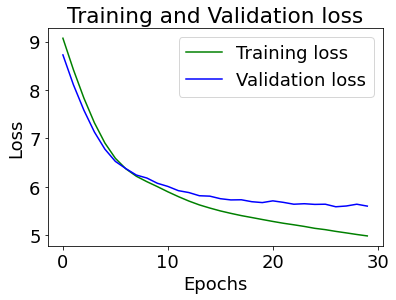

In [3]:
import os
from typing import Optional
from pathlib import Path
import torch

from type_hints import ModelCheckpoint

CHECKPOINT_PATH = Path("checkpoints")
#checkpoint: Optional[ModelCheckpoint] = torch.load(sorted((CHECKPOINT_PATH.glob('*.tar')), reverse=True)[0])
checkpoint = torch.load(CHECKPOINT_PATH / "checkpoint_30_epochs.tar")


loss_train = checkpoint['train_loss_hist']
loss_val = checkpoint['val_loss_hist']
plt.rcParams.update({'font.size': 18})
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
from pathlib import Path

import torch
from torchvision.transforms import Compose

from model.KeypointModel import KeypointModel
from translate import translate

root = '/mnt/data/datasets/cn_sordos_db/data/cuts'
max_frames = 75
use_only_res = True
keypoints_to_use = [i for i in range(94, 136)]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = Path("checkpoints/" if not use_only_res else "checkpoints/res/")


keypoints_transform = Compose([
    get_frames_reduction_transform(max_frames),
    interpolate_keypoints
])
keypoints_transform_each = Compose([
    get_keypoint_format_transform(keypoints_to_use),
    keypoints_norm_to_nose
])

test_dataset = LSA_Dataset(
    root,
    mode='test',
    use_only_res=use_only_res,
    load_videos = False,
    label_as_idx = False,
    keypoints_transform = keypoints_transform,
    keypoints_transform_each = keypoints_transform_each
    )

model = KeypointModel(max_frames, test_dataset.max_tgt_len + 2, len(keypoints_to_use), len(test_dataset.vocab)).to(DEVICE)

checkpoint = torch.load(CHECKPOINT_PATH / "checkpoint_30_epochs.tar")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
labels, preds = [], []
for i in range(0, test_dataset.__len__()):
    if i % 100 == 0:
        print(f"{i}/{len(test_dataset)}")
    _, keys, label = test_dataset.__getitem__(i)
    res = translate(model, keys, test_dataset, DEVICE)
    preds.append(res)
    labels.append(' '.join(label))
    #print(i, res, ' '.join(label))

0/2716
100/2716
200/2716
300/2716
400/2716
500/2716
600/2716
700/2716
800/2716
900/2716
1000/2716
1100/2716
1200/2716
1300/2716
1400/2716
1500/2716
1600/2716
1700/2716
1800/2716
1900/2716
2000/2716
2100/2716
2200/2716
2300/2716
2400/2716
2500/2716
2600/2716
2700/2716


In [ ]:
from torchmetrics.functional import word_error_rate, bleu_score


wer = word_error_rate(preds, labels)
bleu = bleu_score(preds, labels)

In [ ]:
print(wer, bleu)

tensor(1.6418) tensor(0.0010)
